# **2. Language Models  & Word2Vec**

---
## Outline:

1. Language Modelling (N-gram Model)
2. Word Embedding

# **Task 1 : Language Modelling**
---

**Why Language Modelling??**


How to express a language ? There are a lot ,
1. Spoken
2. Written
3. etc


But in above mentioned expression, commonly language expressed through word --> sentence --> paragraph

The manner of it is `sequential`. One word appear after another

We have to remember again the role of machine learning or when to use machine learning.

we can leverage machine learning in language domain

The principle work the same way, by predicting next word / part of word

Why ? It's because machine learning model cannot directly understand language like human do

That simply basic idea of how language model works, but how can we predict what the next word will appear ?

- Simplest approach, given collection of text or `corpus` we can simply count the occurence / word or part of words
- Change the frequency into probability

## N-gram

Let's have an example of a sentence

`He will not come today`

the probability of the sentence occuring could be formulated as

$P(\text{He will not come today}) = P(\text{He}) \cdot P(\text{Will}|\text{He})\cdot P(\text{Come}|\text{He Will}) .. P(\text{today}|\text{He will come })$


We could see that to estimate $P(\text{today} | \text{He will come})$ , we need to condition on 3 previous words. This still okay but what if the sentence length is 20 words length or more

So, instead of using all previous words, we can estimate using n preceeding words. So here we are using chunk of a sentence or `n-gram`.

Example of `1-gram` from sentence `he will not come today` :
- `[('he',), ('will',), ('not',), ('come',), ('today',)]`

We could see that if 1-gram or unigram resulting word-piece.

Example of `2-gram` from sentence `he will not come today` :

- `[('he', 'will'), ('will', 'not'), ('not', 'come'), ('come', 'today')]`

2-gram / bigram result 2 pair of words.

Example of `3-gram` from sentence `he will not come today`

- `[('he', 'will', 'not'), ('will', 'not', 'come'), ('not', 'come', 'today')]`

Resulting 3 pair of words.

So, from this we could reduce into n-gram form, let say we use bigram form
- $P(\text{today} | \text{He will come})$

to :      
- $P(\text{today} | \text{come})$ bigram of `<today,come>`

to 3 gram
- $P(\text{today} | \text{will come})$ trigram of `<will,come,today >`


So, our goal of modelling to calculate the probability of word / given some `ngram-1`  preceeding words.

Our Steps by Steps :      
1. Load Data
2. Performing some preprocessing to handle text data
3. Collect N-gram pairs
4. Calculate probabilities
5. Try to generate a sentence

## Load the data
---

To train language model we need a collection of text or corpus to estimate the occurence of a word / n-gram

In [1]:
# Load this library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# language stuff
import nltk
import re
from nltk import ngrams
from nltk import word_tokenize
from nltk.util import pr


Load the data from given data path

In [2]:
file_path = '../data/artikel_katadata_small.csv'
news_data = pd.read_csv(file_path)

In [3]:
news_data

,text
0,Nilai tukar rupiah dibuka menguat 0\t06% ke le...
1,Anak usaha Alibaba\t Ant Group mencatatkan pen...
2,Harga emas PT Aneka Tambang Tbk mengalami penu...
3,"Dari petani untuk petani, begitulah cerita bag..."
4,BANDUNG – Dalam rangka menyambut HUT Republik ...
5,Xiaomi menguasai pasar Eropa untuk pertama kal...
6,Juru Bicara Vaksinasi Kementerian Kesehatan (K...
7,Ratusanbaliho dan billboard bergambar Ketua DP...
8,Badan Penerbangan dan Antariksa Amerika Serika...
9,Jakarta – Medali emas bersejarah yang diraih G...


We see that, the text itself is not processed yet, such as :     
1. Lowertext
2. Removing Punctuation
3. etc.

You can add any more steps, however usually current approach such as Language Modelling can be directly used

## Text Preprocessing


---

### Create Processing function

In [4]:
def preprocess_tokens(text) :
    """
    Function to preprocess data

    Parameters :
    ----------
    data : pd.DataFrame
         dataframe contain text data
    text_col : str
          column name of text
    """
    # lowercase

    text = text.lower()
    # remove digits
    text = re.sub(r'\d', '', text)


    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\t', '', text)

    # remove whitestrip
    tokens = text.split(' ')

    updated_tokens = []
    not_allowed_tokens = ['']
    updated_tokens = [token for token in tokens if token not in not_allowed_tokens]


    return updated_tokens

In [5]:
news_data['tokenized'] = news_data['text'].apply(preprocess_tokens)
news_data['tokenized']

0    [nilai, tukar, rupiah, dibuka, menguat, ke, le...
1    [anak, usaha, alibaba, ant, group, mencatatkan...
2    [harga, emas, pt, aneka, tambang, tbk, mengala...
3    [dari, petani, untuk, petani, begitulah, cerit...
4    [bandung, dalam, rangka, menyambut, hut, repub...
5    [xiaomi, menguasai, pasar, eropa, untuk, perta...
6    [juru, bicara, vaksinasi, kementerian, kesehat...
7    [ratusanbaliho, dan, billboard, bergambar, ket...
8    [badan, penerbangan, dan, antariksa, amerika, ...
9    [jakarta, medali, emas, bersejarah, yang, dira...
Name: tokenized, dtype: object

### Mapping vocabulary / tokens

we see that the purpose of **Word2Vec** Training is to have representation in terms of vector for each word, during the training process we should intialize the vector, and each vector represented by its location such as row and columns, hence its important to map each token to an id

```
word_to_idx = {"wordA" : 0 ,
               "wordB" : 1,
               ..
               "wordN" : N-1}
```

```
idx_to_word = { 0 :"wordA" ,
                1 : "wordB",
               ..
                N-1: "wordN"}
```

In [6]:
# collect all vocabularies
vocabs = []
for sentences in news_data['tokenized'] :
    for word in sentences :
      vocabs.append(word)

vocabs = list(set(vocabs))

In [7]:
word_to_idx = {word:idx for idx,word in enumerate(vocabs)}
idx_to_word = {idx:word for idx,word in enumerate(vocabs)}

don't forget we have to add special token too sy

In [8]:
word_to_idx

{'jejaring': 0,
 'peningkatan': 1,
 'fokus': 2,
 'kebutuhannya': 3,
 'diselenggarakan': 4,
 'tabungan': 5,
 'kami': 6,
 'juta': 7,
 'menyampaikan': 8,
 'kelola': 9,
 'ahy': 10,
 'pdip': 11,
 'keempat': 12,
 'menyambut': 13,
 'metodiev': 14,
 'up': 15,
 'mengekang': 16,
 'smartphone': 17,
 'faktor': 18,
 'pranowo': 19,
 'memimpin': 20,
 'indonesia': 21,
 'cerita': 22,
 'batangan': 23,
 'ajakan': 24,
 'ketiga': 25,
 'hargabuybackatau': 26,
 'izin': 27,
 'ponsel': 28,
 'tt': 29,
 'bersatu': 30,
 'memperingati': 31,
 'independen': 32,
 'networking': 33,
 'mengungkapkan': 34,
 'terancam': 35,
 'kerja': 36,
 'meski': 37,
 'memberdayakan': 38,
 'usahanya': 39,
 'tinggi': 40,
 'menilai': 41,
 'diwajibkan': 42,
 'stok': 43,
 'mengalami': 44,
 'menaikkan': 45,
 'xiaomi': 46,
 'spesifikasi': 47,
 'olahraga': 48,
 'inilah': 49,
 'filipina': 50,
 'kali': 51,
 'saja': 52,
 'rerata': 53,
 'exchangecomex': 54,
 'kisah': 55,
 'harga': 56,
 'mengucapkan': 57,
 'anggota': 58,
 'pertanian': 59,
 'data': 6

In [ ]:
idx_to_word

{0: 'jejaring',
 1: 'peningkatan',
 2: 'fokus',
 3: 'kebutuhannya',
 4: 'diselenggarakan',
 5: 'tabungan',
 6: 'kami',
 7: 'juta',
 8: 'menyampaikan',
 9: 'kelola',
 10: 'ahy',
 11: 'pdip',
 12: 'keempat',
 13: 'menyambut',
 14: 'metodiev',
 15: 'up',
 16: 'mengekang',
 17: 'smartphone',
 18: 'faktor',
 19: 'pranowo',
 20: 'memimpin',
 21: 'indonesia',
 22: 'cerita',
 23: 'batangan',
 24: 'ajakan',
 25: 'ketiga',
 26: 'hargabuybackatau',
 27: 'izin',
 28: 'ponsel',
 29: 'tt',
 30: 'bersatu',
 31: 'memperingati',
 32: 'independen',
 33: 'networking',
 34: 'mengungkapkan',
 35: 'terancam',
 36: 'kerja',
 37: 'meski',
 38: 'memberdayakan',
 39: 'usahanya',
 40: 'tinggi',
 41: 'menilai',
 42: 'diwajibkan',
 43: 'stok',
 44: 'mengalami',
 45: 'menaikkan',
 46: 'xiaomi',
 47: 'spesifikasi',
 48: 'olahraga',
 49: 'inilah',
 50: 'filipina',
 51: 'kali',
 52: 'saja',
 53: 'rerata',
 54: 'exchangecomex',
 55: 'kisah',
 56: 'harga',
 57: 'mengucapkan',
 58: 'anggota',
 59: 'pertanian',
 60: 'data

## Data Splitting

Since we are not trying to develop model to predict things --> we only need the embeddings from training process --> we don't have to split data into training and test set, since our source of text only consist of 10 news, we can simply divide by indexing

1. Row `1 to 8` belongs to training data
2. Row  `8 to 10` belongs to test data

In [10]:
train_data = news_data.loc[:7,'tokenized'].values.tolist()
test_data = news_data.loc[7:,'tokenized'].values.tolist()

In [11]:
train_data[:2]

[['nilai',
  'tukar',
  'rupiah',
  'dibuka',
  'menguat',
  'ke',
  'level',
  'rp',
  'per',
  'dolar',
  'as',
  'pada',
  'perdagangan',
  'di',
  'pasar',
  'spot',
  'hari',
  'ini',
  'rupiah',
  'diprediksi',
  'masih',
  'akan',
  'melanjutkan',
  'penguatannya',
  'didorong',
  'perbaikan',
  'sentimen',
  'pasar',
  'global',
  'terhadap',
  'aset',
  'berisiko',
  'mengutip',
  'bloomberg',
  'kurs',
  'berbalik',
  'melemah',
  'ke',
  'level',
  'rp',
  'per',
  'dolar',
  'as',
  'hingga',
  'pukul',
  'wib',
  'kendati',
  'posisi',
  'ini',
  'masih',
  'lebih',
  'tinggi',
  'dibandingkan',
  'penutupan',
  'perdagangan',
  'kemarin',
  'di',
  'level',
  'rp',
  'per',
  'dolar',
  'as',
  'mata',
  'uang',
  'asia',
  'lainnya',
  'bergerak',
  'bervariasi',
  'dolar',
  'taiwan',
  'menguat',
  'bersama',
  'dengan',
  'won',
  'korea',
  'selatan',
  'rupee',
  'india',
  'yuan',
  'tiongkok',
  'dolar',
  'hongkong',
  'dan',
  'dolar',
  'singapura',
  'sementar

In [12]:
test_data[:2]

[['ratusanbaliho',
  'dan',
  'billboard',
  'bergambar',
  'ketua',
  'dpp',
  'pdi',
  'perjuangan',
  'sekaligus',
  'ketua',
  'dpr',
  'puan',
  'maharani',
  'tersebar',
  'di',
  'sejumlah',
  'daerah',
  'maraknya',
  'pemasangandisebut',
  'menjadi',
  'upayapartai',
  'banteng',
  'untuk',
  'mendongkrak',
  'elektabilitas',
  'puan',
  'baliho',
  'bergambar',
  'putri',
  'megawati',
  'soekarnoputri',
  'itu',
  'marak',
  'terlihat',
  'di',
  'banyak',
  'titik',
  'dari',
  'jakarta',
  'hingga',
  'kotakota',
  'lainnya',
  'bahkan',
  'polisi',
  'sempat',
  'turun',
  'tangan',
  'usai',
  'salah',
  'satu',
  'baliho',
  'di',
  'blitar',
  'jawa',
  'timur',
  'terkena',
  'aksi',
  'vandalisme',
  'upaya',
  'itu',
  'dilakukan',
  'dalam',
  'rangka',
  'persiapan',
  'pemilihan',
  'presiden',
  'arahnya',
  'ke',
  'sana',
  'ingin',
  'menaikkan',
  'popularitas',
  'dan',
  'elektabilitas',
  'puan',
  'sebagai',
  'capres',
  'atau',
  'cawapres',
  'kata',


## Bigram



In real life we see that words are always tied to another. to do so we can extract the occurence rather than using a sentence we want to resize it to some n-sequence, such as 2,

from sentence :    

`Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.`

Into this :     

`
[('Sometimes', 'while'),
 ('while', 'playing'),
 ('playing', 'a'),
 ('a', 'game,'),
 ('game,', 'you'),
 ('you', 'can'),
 ('can', 'answer'),
 ('answer', 'a'),
 ('a', 'question'),
 ('question', 'correctly'),
 ('correctly', 'but'),
 ('but', 'Alexa'),
 ('Alexa', 'says'),
 ('says', 'you'),
 ('you', 'got'),
 ('got', 'it'),
 ('it', 'wrong'),
 ('wrong', 'and'),
 ('and', 'answers'),
 ('answers', 'the'),
 ('the', 'same'),
 ('same', 'as'),
 ('as', 'you.'),
 ('you.', ''),
 ('', 'I'),
 ('I', 'like'),
 ('like', 'being'),
 ('being', 'able'),
 ('able', 'to'),
 ('to', 'turn'),
 ('turn', 'lights'),
 ('lights', 'on'),
 ('on', 'and'),
 ('and', 'off'),
 ('off', 'while'),
 ('while', 'away'),
 ('away', 'from'),
 ('from', 'home.')]
`


Since, in previous stage we are not yet adding special token mapping `<start` and `<stop>` we should add it first to our mapping

In [13]:
word_to_idx['<start>'] = len(word_to_idx)-1
idx_to_word[len(word_to_idx)-1] = '<start>'


In [14]:
word_to_idx['<stop>'] = len(word_to_idx)-1
idx_to_word[len(word_to_idx)-1] = '<stop>'

In [15]:
# add both words to vocabs
vocabs.append('<start>')
vocabs.append('<stop>')

In [16]:
idx_to_word

{0: 'jejaring',
 1: 'peningkatan',
 2: 'fokus',
 3: 'kebutuhannya',
 4: 'diselenggarakan',
 5: 'tabungan',
 6: 'kami',
 7: 'juta',
 8: 'menyampaikan',
 9: 'kelola',
 10: 'ahy',
 11: 'pdip',
 12: 'keempat',
 13: 'menyambut',
 14: 'metodiev',
 15: 'up',
 16: 'mengekang',
 17: 'smartphone',
 18: 'faktor',
 19: 'pranowo',
 20: 'memimpin',
 21: 'indonesia',
 22: 'cerita',
 23: 'batangan',
 24: 'ajakan',
 25: 'ketiga',
 26: 'hargabuybackatau',
 27: 'izin',
 28: 'ponsel',
 29: 'tt',
 30: 'bersatu',
 31: 'memperingati',
 32: 'independen',
 33: 'networking',
 34: 'mengungkapkan',
 35: 'terancam',
 36: 'kerja',
 37: 'meski',
 38: 'memberdayakan',
 39: 'usahanya',
 40: 'tinggi',
 41: 'menilai',
 42: 'diwajibkan',
 43: 'stok',
 44: 'mengalami',
 45: 'menaikkan',
 46: 'xiaomi',
 47: 'spesifikasi',
 48: 'olahraga',
 49: 'inilah',
 50: 'filipina',
 51: 'kali',
 52: 'saja',
 53: 'rerata',
 54: 'exchangecomex',
 55: 'kisah',
 56: 'harga',
 57: 'mengucapkan',
 58: 'anggota',
 59: 'pertanian',
 60: 'data

In [17]:
bigram_frequency = np.zeros((len(vocabs), len(vocabs)), dtype='int')

for news in news_data['tokenized'].values :
    words = ['<start>'] + list(news) + ['<stop>']
    for word_1, word_2 in zip(words, words[1:]):

      word_1_idx = word_to_idx[word_1]
      word_2_idx = word_to_idx[word_2]
      bigram_frequency[word_1_idx,word_2_idx] += 1




In [18]:
bigram_frequency.shape

(1391, 1391)

In [19]:
bigram_pair = pd.DataFrame()
for idx_1 in range(10):
        first_gram = idx_to_word[idx_1]
        bigram_pair[first_gram] = bigram_frequency[idx_1]
bigram_pair = bigram_pair.iloc[:20]
bigram_pair.index = [idx_to_word[idx] for idx in range(20)]

In [20]:
bigram_pair

,jejaring,peningkatan,fokus,kebutuhannya,diselenggarakan,tabungan,kami,juta,menyampaikan,kelola
jejaring,0,0,0,0,0,0,0,0,0,0
peningkatan,0,0,0,0,0,0,0,0,0,0
fokus,0,0,0,0,0,0,0,0,0,0
kebutuhannya,0,0,0,0,0,0,0,0,0,0
diselenggarakan,0,0,0,0,0,0,0,0,0,0
tabungan,0,0,0,0,0,0,0,0,0,0
kami,0,0,0,0,0,0,0,0,0,0
juta,0,0,0,0,0,0,0,0,0,0
menyampaikan,0,0,0,0,0,0,0,0,0,0
kelola,0,0,0,0,0,0,0,0,0,0


we can see that a lot of word has zero frequency, what we are going to do ? add 1 to all bigram pair

In [21]:
bigram_frequency = bigram_frequency+1

In [22]:
bigram_pair = pd.DataFrame()
for idx_1 in range(10):
        first_gram = idx_to_word[idx_1]
        bigram_pair[first_gram] = bigram_frequency[idx_1]
bigram_pair = bigram_pair.iloc[:20]
bigram_pair.index = [idx_to_word[idx] for idx in range(20)]
bigram_pair

,jejaring,peningkatan,fokus,kebutuhannya,diselenggarakan,tabungan,kami,juta,menyampaikan,kelola
jejaring,1,1,1,1,1,1,1,1,1,1
peningkatan,1,1,1,1,1,1,1,1,1,1
fokus,1,1,1,1,1,1,1,1,1,1
kebutuhannya,1,1,1,1,1,1,1,1,1,1
diselenggarakan,1,1,1,1,1,1,1,1,1,1
tabungan,1,1,1,1,1,1,1,1,1,1
kami,1,1,1,1,1,1,1,1,1,1
juta,1,1,1,1,1,1,1,1,1,1
menyampaikan,1,1,1,1,1,1,1,1,1,1
kelola,1,1,1,1,1,1,1,1,1,1


Next, we can convert into probability values what can we do ?
We can calculate it row piece


In [23]:
bigram_frequency.sum(axis=1)

array([1393, 1394, 1392, ..., 1403, 1391, 1391])

In [24]:
bigram_proba = bigram_frequency.copy()
bigram_proba = bigram_proba / bigram_proba.sum(axis=1,keepdims=True)

In [25]:
bigram_pair = pd.DataFrame()

for idx_1 in range(10):
        first_gram = idx_to_word[idx_1]
        bigram_pair[first_gram] = bigram_frequency[idx_1]
bigram_pair = bigram_pair.iloc[:20]
bigram_pair.index = [idx_to_word[idx] for idx in range(20)]
bigram_pair

,jejaring,peningkatan,fokus,kebutuhannya,diselenggarakan,tabungan,kami,juta,menyampaikan,kelola
jejaring,1,1,1,1,1,1,1,1,1,1
peningkatan,1,1,1,1,1,1,1,1,1,1
fokus,1,1,1,1,1,1,1,1,1,1
kebutuhannya,1,1,1,1,1,1,1,1,1,1
diselenggarakan,1,1,1,1,1,1,1,1,1,1
tabungan,1,1,1,1,1,1,1,1,1,1
kami,1,1,1,1,1,1,1,1,1,1
juta,1,1,1,1,1,1,1,1,1,1
menyampaikan,1,1,1,1,1,1,1,1,1,1
kelola,1,1,1,1,1,1,1,1,1,1


What can we do with language model ?
1. Generating a sentence

### Generating Sentences : Bigram example

We see that n-gram model is count based only, we don't literally use modelling step such as **Optimization**.

Similarly like KNN method

Okay, now its time to begin generate sentence, since we are using bigram we need to have one prior word or token, we should begin it using our identifier such as `<start>`

filter it first by finding which n gram has `<start>` as it first sequence

we can use sampling, or using the most probable word

In [26]:
generated_words = ['<start>']

# get last token
n_words = 10
for pos in range(n_words) :
    # get last token
    last_token = generated_words[-1]
    # get last token idx
    idx = word_to_idx[last_token]
    # get bigram
    proba_array = bigram_proba[idx]
    # argmax
    word_idx = np.argmax(proba_array)
    # get word
    generated_words.append(idx_to_word[word_idx])


# add terminating token
generated_words.append('<stop>')
' '.join(generated_words)

'<start> tersebut merupakan ajakan kepada bahan baku impor fokus kita perlu <stop>'

In [27]:
np.array([4]).item()

4

In [28]:
# using sampling
generated_words = ['<start>']

# get last token
n_words = 10
for pos in range(n_words) :
    # get last token
    last_token = generated_words[-1]
    # get last token idx
    idx = word_to_idx[last_token]
    # get bigram
    proba_array = bigram_proba[idx]
    # sampling using probability
    word = np.random.choice(a=vocabs,size=1,p=proba_array).item()
    # get word
    generated_words.append(word)


# add terminating token
generated_words.append('<stop>')
' '.join(generated_words)

'<start> berat nilai mengunjungi kotakota adi persiapan dukungan tt mesir mengekang <stop>'

So, how can we create higher n-gram model ? such as trigram model, 4-gram model , the approach is the same

# **Task  2 : Word Vector**
---

Previously, we have already learn a way to convert a sentence into a vector, count based approach, such as :
1. Bag of Words
2. tf-idf
3. etc



However there are some problem with that :    

1. The dimension grow as the vocabulary grow
2. The vector value is sparse (**contain lot of zeros**)

So, what is the solution ?
Set our goals, we want to have fix length vector with dense value (non-zero)

Here's come word two vec as solution

Usually vector called as **embeddings**

<a href="https://imgflip.com/i/851a2g"><img src="https://i.imgflip.com/851a2g.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>

There are two variants of Word2Vec :     
1. Skipgram
2. Continunous Bag of Words

The notebook will try to train Skipgram model from scratch

## Skipgram WordVec from scratch
---

`The idea is that the word that are appearing closely should have similar vector / embedding`

But, how to express that ?

Remember that usually in a sentence, each word appear sequentially

Appearing closely is relative, depends on how we set the range, or the `window size` , in this case we use window size of 1 word before and after.

<center>
<img src="../assets/n_gram_word2vec/n_gram.jpg" >
</center>

So our goal is to train model to classify given target word and some words whether it's context word or not ~ Binary Classification Task.

You will realize that word2vec can be approached simply like logistic regression , however we have additional step to update embeddings and obtain the embeddings.

<center>
<img src="../assets/n_gram_word2vec/input_output_ngram.JPG" >

## Training Model from Scratch

### Collect Training Data
In the beginning section we know that we are going to train model to distinguish where the context word is given target data.

The process is simple
1. If word is in window from target word --> context label has value 1
2. Otherwise --> 0

<img src="../assets/n_gram_word2vec/training_n_gram.jpg" >

#### Collect Positive Samples

In [29]:
n_windows = 2
context_words = [ ]
target_word_list = []
labels = []


def add_context(sentence, idx, offset,
                context_words=context_words,
                target_word_list=target_word_list,
                labels=labels):
    """
        Function to collect context word based on sliding window

        Parameters :
        ------------
        sentence : Iterables such as list, array etc
        idx : int
            position in sliding window
        offset : number of sliding window
        context_words : List
          container to store context words
        target_word_list : List
          container to store target words
        labels : List
          container to store label

        Returns :
        ------------
        -

    """
    if 0 <= idx + offset < len(sentence):
        context_idx = word_to_idx[sentence[idx + offset]]
        target_idx = word_to_idx[sentence[idx]]
        context_words.append(context_idx)
        target_word_list.append(target_idx)
        labels.append(1)


create function to collect positive samples

In [30]:
def collect_positive_samples(text_collection,n_windows=2) :
    """
        Function to collect positive samples

        Parameters :
        ------------
        text_collection : Iterables such as list, array etc
            contain tokenized corpus
        n_windows : int
            default = 2 , number of sliding window
        Returns :
        ------------
        target_word_list : List
              target words idx
        context_words : List
              context words idx
        labels : List
              labels 0 / 1
    """
    context_words = [ ]
    target_word_list = []
    labels = []

    for sentence in text_collection :
      for idx, target_word in enumerate(sentence):
          # get context tokens
          for pos in range(1, n_windows+1):
              # add after posision
              add_context(sentence, idx, pos,
                          context_words= context_words,
                          target_word_list= target_word_list,
                          labels= labels)
              # add before position
              add_context(sentence, idx, -pos,
                          context_words= context_words,
                          target_word_list= target_word_list,
                          labels= labels)

    return target_word_list,context_words,labels

In [31]:
target_word_list,context_words,labels = collect_positive_samples(text_collection = news_data['tokenized'].values)

In [32]:
print(f'First 5 of data :\n Target Words  {target_word_list[:5]} ,\n Context Words  {context_words[:5]},\nLabels  {labels[:5]}')

First 5 of data :
 Target Words  [156, 156, 917, 917, 917] ,
 Context Words  [917, 770, 770, 156, 459],
Labels  [1, 1, 1, 1, 1]


#### Collect Negative Samples

Now its time to collect negative sample, hence we are random choosing negative samples, we need to perform sampling on words that are not in positive context word. What we can do :    
1. Collect each positive words in given target word
2. Slice using set operation to collect possible negative words
3. Perform sampling to choose some of them

In [33]:
def collect_positive_index(text_collection) :
    """
    Function to collect positive context word given target word

    Parameters :
    -----------
    text_collection : List / Iterables
        training corpus
    Returns :
    ---------
    target_word_idx : Dictionary
          keys : target word idx
          values : list of each positive words idx
    """
    target_word_idx = {}
    for sentence in text_collection :
      for idx,target_word in enumerate(sentence) :
          # collect index position
          if target_word not in list(target_word_idx.keys()) :
              target_word_idx[target_word] = []
              target_word_idx[target_word].append(idx)
          else :
            target_word_idx[target_word].append(idx)

    return target_word_idx

In [34]:
target_positive_word_idx = collect_positive_index(news_data['tokenized'].values)

Create function to collect negative samples :

In [35]:
def collect_negtive_samples(target_word_list,
                            context_words,
                            labels,
                            pos_word_idx,
                            n_negative=5,vocabs=vocabs) :
    """
        Function to collect negative samples

        Parameters :
        ------------
        target_word_list : List
              target words idx
        context_words : List
              context words idx
        labels : List
              labels 0 / 1
        pos_word_idx : Dict
              contain earch target word idx , for slicing positive / context word
        n_negative : int
              number of negative words to be sampled, default to 5
        vocabs : List
            vocabulary

        Returns :
        ------------
        target_word_list : List
              target words idx
        context_words : List
              context words idx
        labels : List
              labels 0 / 1
    """
    # avoid overwriting
    target_word_list = target_word_list.copy()
    context_words = context_words.copy()
    labels = labels.copy()

    for target_word in pos_word_idx.keys() :
        # slice positive word position
        pos_word_idx = pos_word_idx[target_word]
        # retrieve context word
        pos_word = np.array(context_words)[pos_word_idx]

        # perform set difference operation
        neg_words = list(set(vocabs).difference(set(pos_word)))
        # perform sampling on negative word
        neg_sampled = np.random.choice(neg_words,n_negative)

        # collect all negative sample
        for neg in neg_sampled :
            # append the data
            context_idx = word_to_idx[neg]
            target_idx = word_to_idx[target_word]
            context_words.append(context_idx)
            target_word_list.append(target_idx)
            labels.append(0)

        return target_word_list,context_words,labels


In [36]:
target_word_list, context_words,labels = collect_negtive_samples(target_word_list,
                                                                  context_words,
                                                                  labels,
                                                                  pos_word_idx = target_positive_word_idx)

In [37]:
print(f'Last 5 of data :\n Target Words  {target_word_list[-5:]} ,\n Context Words  {context_words[-5:]},\nLabels  {labels[-5:]}')

Last 5 of data :
 Target Words  [156, 156, 156, 156, 156] ,
 Context Words  [1353, 1026, 1218, 69, 1238],
Labels  [0, 0, 0, 0, 0]


#### Create Function to Collect Both Training Data

In [38]:
def collect_training_data(text_collection,n_windows=2,n_negative=5) :
    """
    Function to collect training data (positive and negative samples)

    Parameters :
    ------------
    text_collection : Iterables such as list, array etc
    n_windows : int
        number of windows length n-previous and n-after target word
    n_negative : number of negative samples to take for each target word

    Returns :
    ------------
    training_data : np.array
        training data with col 1 : target_array,
                           col 2 : context_array,
                           col 3 : labels

    """
    target_word_list, context_words,labels = collect_positive_samples(text_collection)
    target_positive_word_idx = collect_positive_index(text_collection)
    target_word_list, context_words,labels = collect_negtive_samples(target_word_list,
                                                                  context_words,
                                                                  labels,
                                                                  pos_word_idx = target_positive_word_idx,
                                                                  n_negative=5,vocabs=vocabs)
    # convert to numpy array
    target_array = np.asarray(target_word_list)
    context_array = np.asarray(context_words)
    labels_array = np.asarray(labels)
    # return array of context_word,target_word,label --?
    training_data = np.vstack([target_array,context_array,labels_array]).T

    return training_data

In [39]:
training_data = collect_training_data(text_collection = news_data['tokenized'].values,n_windows=2,n_negative=5)

In [40]:
training_data

array([[ 156,  917,    1],
       [ 156,  770,    1],
       [ 917,  770,    1],
       ...,
       [ 156, 1225,    0],
       [ 156,  275,    0],
       [ 156,  962,    0]])

### Initialize Vector

<center>
<img src="../assets/n_gram_word2vec/n_gram_process.jpg" width=800 height=500>

The vector we are going to generate have size of `<n_vocabs x vector_dimension>`.

There are some ways to initialize the vector :
1. Filling with some fixed values , like `0` or `1`
2. Sampling from some distribution, like `Normal Distribution`

In this case, we will try to use `second` method, to sample from `Standard Normal Distribution` which have property of $\mu=1$ and $\sigma^2 = 1$.

In [41]:
n_tokens = len(vocabs)
vector_length = 100


target_word_vec = np.random.normal(0.,1.,size=(n_tokens,vector_length))
word_vec = np.random.normal(0.,1.,size=(n_tokens,vector_length))

In [42]:
word_vec.shape

(1391, 100)

Let's see word vector for **dolar**

In [43]:
# get id for recent
word_idx = word_to_idx['dolar']
# get vector
word_vec[word_idx]

array([ 1.08852022e+00,  5.58316588e-02,  3.72202691e-01, -1.67251109e+00,
        1.67170652e-01,  2.23520556e-03, -2.50387865e-01, -1.93118985e+00,
       -7.44739163e-01, -1.04819294e+00,  1.02275851e+00,  3.93317927e-01,
        1.24734430e-01, -1.17816197e-01, -2.62535445e-01, -8.44035051e-02,
        7.18405830e-01, -8.27907856e-01,  7.90356075e-01, -4.85799995e-02,
       -1.99195585e-01,  1.88558435e+00,  9.57374003e-01,  3.18277227e-01,
        4.42162200e-01, -1.11641365e+00,  1.56560138e+00, -1.08496705e+00,
       -2.46619966e-01, -5.23086333e-01, -1.23999371e+00,  1.30036980e-01,
        1.06783900e+00, -1.75416035e+00,  8.94530658e-01,  2.08410731e+00,
        3.83435418e-01,  4.67850602e-01,  2.40386179e-01,  1.15123153e+00,
       -2.82733742e+00, -1.06761875e+00,  1.59050615e-01,  2.62472733e-01,
        1.47365399e+00, -3.02309707e-01, -7.49967163e-01,  1.63044629e-01,
       -1.18842254e+00,  6.48240812e-01,  1.01134937e+00,  1.14628352e+00,
        4.12372028e-01, -

In [44]:
# get id for recent
word_idx = word_to_idx['dolar']
# get vector
target_word_vec[word_idx]

array([-2.35430876e+00,  1.02483823e+00,  5.32005947e-02,  2.17610573e-01,
       -1.10026671e+00, -5.42546899e-01, -5.43971830e-01, -7.90724341e-01,
        8.25692446e-01, -2.11388695e+00, -1.87622606e+00,  1.47014727e+00,
       -1.70817749e+00, -1.71292173e+00, -1.96476438e-01,  1.34476082e+00,
       -5.44136445e-01,  8.84489436e-01,  1.46024479e+00, -1.80533903e+00,
        2.38010095e-02, -6.53449267e-01,  1.24993120e+00, -1.36415618e+00,
       -8.10637355e-01,  1.11518813e+00,  6.19573532e-01,  2.72041092e-01,
        1.23461443e+00,  7.89814013e-01, -1.29704731e+00, -1.26957968e+00,
       -4.27034782e-01, -2.46478464e+00, -3.17425084e-02, -6.43326208e-01,
       -5.40218212e-01,  1.58485215e-01,  6.44222543e-02,  5.03644192e-02,
        7.18928879e-01,  7.78172137e-02,  5.91671773e-01, -3.67663303e-01,
        1.06752892e+00, -3.19693982e-01, -6.85960519e-01,  1.56568895e+00,
        1.28551939e-01,  1.91936843e+00,  9.91456260e-01,  5.86209254e-01,
       -3.23229001e-01,  

In [45]:
training_data[:,2]

array([1, 1, 1, ..., 0, 0, 0])

### Train the Model

The Workflow during model training :
Iterate all training data and do :     
1. Predict whether context word and target word is `indeed` a context
2. Calculate the loss
3. Update using gradient Descent each vector

In [46]:
def sigmoid(x) :
  return 1 / (1 + np.exp(-x))

In [47]:
from tqdm import tqdm
def grad_descent_update(training_data,word_vec,target_word_vec,lr=0.0001,n_epoch=100) :
    """
    Function to update the word2vec vector
    Parameters :
    -----------
    training_data : np.array
      training data with col 1 : target_array,
                        col 2 : context_array,
                        col 3 : labels
    word_vec : np.array
      vector for each word size <n_vocabs x n_dim>
    target_word_vec : np.array
      vector for each word size <n_vocabs x n_dim>
    lr : float
      learning rate (gd) to update the word vector and target_word_vector
    n_epoch : int
      number of iteration
    Returns :
    --------
    word_vec : np.array
      updated vector for each word size <n_vocabs x n_dim>
    target_word_vec : np.array
      updated vector for each word size <n_vocabs x n_dim>
    loss_training : List
      average loss for each epoch

    """
    # copy to avoid overwriting the vector
    word_vec = word_vec.copy()
    target_word_vec = target_word_vec.copy()

    # setting seed for reproducibility
    np.random.seed(100)
    # create container for loss
    loss_training = []
    # loop all over epoch
    for epoch in tqdm(range(n_epoch)) :
      loss_per_epoch = []
      for idx in range(training_data.shape[0]) :
          # slice word
          word_idx = training_data[idx][0]
          # slice target word
          target_word_idx = training_data[idx][1]
          # slice label
          label = training_data[idx][2]
          # slice vector
          word_vector = word_vec[word_idx]
          target_word_vector = target_word_vec[target_word_idx]
          # perform dot product
          dot_result = np.dot(word_vector,target_word_vector.T)

          # output probabilities --> sigmoid
          proba = sigmoid(dot_result)

          # calculate loss
          eps = 0.0001
          loss = -((label * np.log(proba+eps)) + ((1 - label) * np.log(1 - proba+eps)))


          # append loss
          loss_per_epoch.append(loss)
          # calculate derivative
          word_vector_derivative = (label-proba)*target_word_vector

          target_vector_derivative = (label-proba)*word_vector

          # update weight
          word_vec[word_idx] += lr*(word_vector_derivative)
          target_word_vec[target_word_idx] += lr*(target_vector_derivative)


      # calculate average loss # append average loss
      loss_training.append(np.mean(loss_per_epoch))
      if (epoch+ 1) % 10 == 0 :
        print(f'\nEpoch : {epoch+ 1} Loss {np.mean(loss_per_epoch)}')

    return word_vec,target_word_vec,loss_training


In [48]:
word_vec_updated,target_word_vec_updated,loss_training = grad_descent_update(training_data=training_data,word_vec=word_vec,
                                                 target_word_vec=target_word_vec,
                                                 lr=0.001,n_epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [00:02<00:08,  4.39it/s]


Epoch : 10 Loss 2.3147631323754037


 42%|████▏     | 21/50 [00:04<00:07,  4.13it/s]


Epoch : 20 Loss 1.7295930812151754


 60%|██████    | 30/50 [00:07<00:05,  3.87it/s]


Epoch : 30 Loss 1.2954257264732743


 82%|████████▏ | 41/50 [00:09<00:02,  3.89it/s]


Epoch : 40 Loss 0.9674957096353828


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch : 50 Loss 0.7189311415029047


Plot the Loss

Text(0, 0.5, 'Loss')

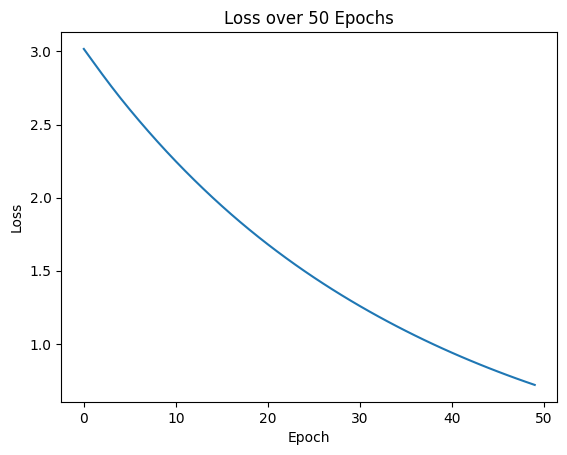

In [49]:
fig,ax = plt.subplots()
plt.plot([x for x in range(50)],loss_training)
plt.title('Loss over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

What we will do after we have a vector representation from each words ?

**We can do A Lot!**

One of them is , we can measure similarity between words.

According to Speech and Language Processing book, we can use several way to use the vector representation.
1. Using only Word Vector.
2. Adding Word Vector + Target word Vector.

We will try both with example of 3 words :
1. `indonesia`
2. `amerika`
3. `pekerjaan`


**Using word vector + target vector**

In [50]:
#retrieve vector for each
indo_idx = word_to_idx['indonesia']
as_idx = word_to_idx['amerika']
pekerjaan_idx = word_to_idx['pekerjaan']

indo_vector = word_vec_updated[indo_idx] + target_word_vec_updated[indo_idx]
as_vector = word_vec_updated[as_idx] + target_word_vec_updated[as_idx]
pekerjaan_vector = word_vec_updated[pekerjaan_idx]+ target_word_vec_updated[pekerjaan_idx]



In [51]:
indo_vector.shape

(100,)

In [52]:
as_vector

array([ 0.0849225 , -1.24251252, -1.83877871, -2.0801041 , -0.81113344,
       -0.18733682,  0.14215604,  1.99532355, -0.69201623,  0.74091619,
       -1.56723294, -2.54939973,  2.30954269,  1.55477333,  1.14206733,
       -0.49367509,  0.70318802, -0.94978199,  0.11303497, -0.03472984,
        2.35408871, -0.5216032 , -0.01202174, -0.76525264,  0.52440101,
       -1.20680768,  1.48939006,  1.22416408, -1.26694418,  0.91437363,
        1.19131961, -0.18613975, -1.19388181, -0.14583371,  0.20766452,
        0.46922198, -0.5668541 ,  1.60855091,  2.01994031,  1.28427937,
        1.5531637 ,  0.27892755,  0.64971897,  2.89920842, -0.12633973,
        1.04577697,  0.95889586,  2.0709979 ,  2.86983833, -3.17236633,
        0.05140432,  1.32553646, -1.80356807, -1.47683492, -0.98221096,
       -0.04627888,  1.79378411,  1.48828381, -0.61079818, -0.4846104 ,
        2.52098001, -0.48988404, -0.94751569, -2.0762776 , -0.63147807,
       -0.9516631 ,  1.61252146,  1.48033996, -0.16464744,  0.84

In [53]:
# calculate similarities
from numpy.linalg import norm
def cosine_similarity (vecA,vecB) :
  return np.dot(vecA,vecB.T) / (norm(vecA)*norm(vecB))

sim_as_indo = cosine_similarity(indo_vector,as_vector)
sim_indo_pekerjaan = cosine_similarity(indo_vector,pekerjaan_vector)

In [54]:
print(f'Similarity between (as and indonesia) ={sim_as_indo} > (indonesia & pekerjaan) ={sim_indo_pekerjaan}',sim_as_indo > sim_indo_pekerjaan )

Similarity between (as and indonesia) =-0.1103431655863613 > (indonesia & pekerjaan) =0.00640656301316653 False


**Using Word Vector Only**

In [55]:
indo_idx = word_to_idx['indonesia']
as_idx = word_to_idx['amerika']
pekerjaan_idx = word_to_idx['pekerjaan']

indo_vector = word_vec_updated[indo_idx]
as_vector = word_vec_updated[as_idx]
pekerjaan_vector = word_vec_updated[pekerjaan_idx]

In [56]:
sim_as_indo_word = cosine_similarity(indo_vector, as_vector)
sim_indo_pekerjaan_word = cosine_similarity(indo_vector, pekerjaan_vector)
print(f'Similarity between (as and indonesia) ={sim_as_indo_word} > (indonesia & pekerjaan) ={sim_indo_pekerjaan_word}',sim_as_indo_word > sim_indo_pekerjaan_word )

Similarity between (as and indonesia) =0.021353725932818864 > (indonesia & pekerjaan) =-0.02540040480264364 True


**Recap**

From both approach, we can see the result is still the same

| pair                      | indo & amerika similarity | indo + pekerjaan similarity | is indo & amerika > indo & similarity |
|---------------------------|---------------------------|-----------------------------|---------------------------------------|
| target word + word vector |      -0.10256010380344176           |       0.02477290348227598                  |       False                                |
| word vector only          |          -0.13936567330960714                  |     -0.03442182510779406                        |                 False                      |

## Word Embedding playground
---

Now, our sentence already has feature representation

Now, let's plot our embeding result in 2D, how are we going to do that ? Remember we have embeddings with dimension of 100. Can we compress the dimension without losing much information.


Some options :    
1. PCA
2. t-SNE

for now, let's use `t-SNE`

If you want to learn more about `t-SNE`, you can check [here](https://distill.pub/2016/misread-tsne/)



In [57]:
import numpy as np
from sklearn.manifold import TSNE

word_vector_compressed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(word_vec)
word_vector_compressed.shape

(1391, 2)

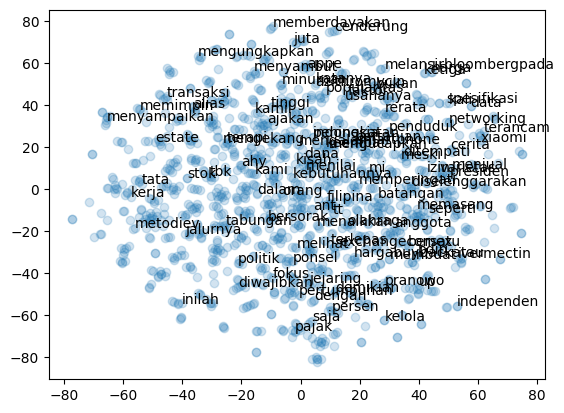

In [58]:

plt.scatter(word_vector_compressed[:,0],word_vector_compressed[:,1],alpha=0.2)

for word in vocabs[:100] :
  # get word idx
  idx = word_to_idx[word]
  vector= word_vector_compressed[idx]
  plt.text(vector[0],vector[1],word)
  # plt.annotate(word,
  #             xy=(), xycoords='figure pixels')

We can see that some word are closed together, and some words are not , the more closed words the more similar in terms of meaning or context / related

In [59]:
from gensim.test.utils import common_texts
from gensim.models import word2vec

In [60]:
model = word2vec.Word2Vec(sentences=news_data['tokenized'].values.tolist(), vector_size=100, window=1, min_count=1, workers=4)


In [61]:
model.wv.most_similar(positive='amerika')

[('vaksinasi', 0.30481022596359253),
 ('airlangga', 0.2817544937133789),
 ('bersatu', 0.268802285194397),
 ('beralasan', 0.265508770942688),
 ('terapi', 0.263418585062027),
 ('galaxy', 0.2622656226158142),
 ('menurutnya', 0.25982290506362915),
 ('nenengtak', 0.25592944025993347),
 ('tetap', 0.25391438603401184),
 ('aneka', 0.2532925009727478)]

Finding most similar word related to a word

In [62]:
vector_representation = word_vec_updated + target_word_vec_updated

Finding most similar words / related words for Indonesia

In [63]:
# get index for words = indonesia
indo_idx = word_to_idx['indonesia']
indonesia_vector = vector_representation[indo_idx]

indonesia_vector

array([ 0.09825292, -0.76090658, -0.93546054, -0.62370167,  0.72281259,
        1.41422687, -0.60940596, -2.38391118, -0.16060787,  2.20023298,
       -0.55472004,  1.2217261 , -2.30332409, -0.59519267, -2.28086421,
        0.67430202,  0.69697099,  0.02565604,  1.96835887,  1.08255439,
        0.60859277,  1.80049143,  0.54314296, -3.47429286, -0.14066493,
        2.60261625, -0.03514376, -0.5074712 , -2.14001465, -2.2839785 ,
        0.82001123,  0.11054176,  0.115959  ,  1.86702666,  4.19048097,
       -0.77801518, -0.32272198, -1.13540047,  0.66435563,  0.93948997,
        0.96863427,  0.01152051, -1.16369504,  0.24542011,  0.35574442,
       -1.06208957, -0.65924616, -2.86939237, -1.61119592, -0.51984575,
       -0.56944228,  0.23953669,  1.29605661, -1.37515865, -0.66001946,
        0.39543729, -1.03885573,  0.11989191,  0.52552696,  0.16488358,
       -0.24417457,  1.81029079,  0.57105178,  0.18449584,  1.29648969,
       -1.29743985,  0.6116866 , -1.46070122,  1.40735733,  2.16

In [64]:
# loop all over vocabulary
# pick 10 most similar words
n_top = 10
similarities_result = []
for word in vocabs :
    # get word idx
    word_idx = word_to_idx[word]
    word_vector = vector_representation[word_idx]
    # calculate similarity
    word_sim = cosine_similarity(indonesia_vector,word_vector)
    similarities_result.append(word_sim)

# set as array
similarity_arr = np.asarray(similarities_result)
# sort with index
most_similar_words = np.argsort(similarity_arr)[::-1][:n_top]
most_similar_words

array([  21, 1114,  887, 1329, 1325, 1014,  395, 1203,  338,  957])

In [65]:
for idx in most_similar_words :
    # get word
    word = vocabs[idx]
    # similarity
    sim = similarity_arr[idx]
    # print the result
    print(f'Most Similar Words to Indonesia :{word} Similarity Score {sim}')

Most Similar Words to Indonesia :indonesia Similarity Score 1.0
Most Similar Words to Indonesia :penguatannya Similarity Score 0.3226535932214162
Most Similar Words to Indonesia :diganti Similarity Score 0.2719582472542564
Most Similar Words to Indonesia :barang Similarity Score 0.2712637070205291
Most Similar Words to Indonesia :perkebunan Similarity Score 0.2667830551083863
Most Similar Words to Indonesia :naik Similarity Score 0.26673036952991036
Most Similar Words to Indonesia :runnerup Similarity Score 0.2502885866329254
Most Similar Words to Indonesia :nilainya Similarity Score 0.24602408310712123
Most Similar Words to Indonesia :bertambah Similarity Score 0.24577276563298076
Most Similar Words to Indonesia :lonjakan Similarity Score 0.24394166414094628


Now, also we can create a function to find more words

In [66]:
def find_similar_words(word_to_find,word_vector,vocabs,word_to_idx,n_top=10) :

    # get index for words
    search_word_idx = word_to_idx[word_to_find]
    # get the vector
    search_vector = vector_representation[search_word_idx]

    # loop all over the words
    similarities_result = []
    for word in vocabs :
        # get word idx
        word_idx = word_to_idx[word]
        vector = word_vector[word_idx]
        # calculate similarity
        word_sim = cosine_similarity(search_vector,vector)
        similarities_result.append(word_sim)

    # set as array
    similarity_arr = np.asarray(similarities_result)
    # sort with index
    similarity_word = np.argsort(similarity_arr)
    most_similar_words = np.argsort(similarity_arr)[::-1][:n_top]
    # get most similar score
    most_similar_score = similarity_arr[most_similar_words]

    similar_word = []
    similarity_score = []
    for idx in most_similar_words :
        # get word
        word = vocabs[idx]

        # similarity
        sim = similarity_arr[idx]

        # print the result
        print(f'Most Similar Words to {word_to_find} :{word} ,similarity Score {sim}')

    # return most similar word with its score
    return most_similar_words, most_similar_score



In [67]:
_ = find_similar_words(word_to_find = 'amerika',word_vector=vector_representation,
                   vocabs = vocabs,word_to_idx = word_to_idx ,n_top=10)

Most Similar Words to amerika :amerika ,similarity Score 1.0
Most Similar Words to amerika :mampu ,similarity Score 0.2968100473263189
Most Similar Words to amerika :jaminan ,similarity Score 0.2894026647166615
Most Similar Words to amerika :<start> ,similarity Score 0.28661592016337983
Most Similar Words to amerika :spanduk ,similarity Score 0.28661592016337983
Most Similar Words to amerika :relatif ,similarity Score 0.2790002963008862
Most Similar Words to amerika :dilansir ,similarity Score 0.2781374541098771
Most Similar Words to amerika :fermentasi ,similarity Score 0.27696609354859614
Most Similar Words to amerika :transfer ,similarity Score 0.27657511796538164
Most Similar Words to amerika :dihubungi ,similarity Score 0.27313513825255437


In [68]:
_ = find_similar_words(word_to_find = 'pekerjaan',word_vector=vector_representation,
                   vocabs = vocabs,word_to_idx = word_to_idx ,n_top=10)

Most Similar Words to pekerjaan :pekerjaan ,similarity Score 1.0000000000000002
Most Similar Words to pekerjaan :disebabkan ,similarity Score 0.31547936641581503
Most Similar Words to pekerjaan :kramadibrata ,similarity Score 0.30552577992920976
Most Similar Words to pekerjaan :bersoda ,similarity Score 0.2998854305705239
Most Similar Words to pekerjaan :agrolestari ,similarity Score 0.2828748760964139
Most Similar Words to pekerjaan :boris ,similarity Score 0.2736715506930984
Most Similar Words to pekerjaan :baru ,similarity Score 0.2721657419190241
Most Similar Words to pekerjaan :penghidupan ,similarity Score 0.267859827018541
Most Similar Words to pekerjaan :bulan ,similarity Score 0.2674387777440524
Most Similar Words to pekerjaan :berarti ,similarity Score 0.2632881467245231
